<a href="https://colab.research.google.com/github/the-bucketless/basketball/blob/main/fiba_shot_chart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FIBA Shot Chart

This is a quick notebook I threw together to show how to access a couple different areas of the FIBA API. It's going to look at putting together a shot chart like the one displayed for games.

In [1]:
!pip install hockey-rink -q

In [2]:
from hockey_rink import Rink, RinkCircle, RinkFeature, RinkRectangle
import json
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import pandas as pd
import requests

This is the ID for the 2022 Women's World Cup. I haven't tested to see if it works on any others.

In [3]:
tournament_id = 208410    #@param

## Schedule

We'll start by grabbing the schedule. From this, we can see which games are likely to be available and grab the "GameKey" for them.

In [4]:
schedule_url = (
    "https://livecache.sportresult.com/node/db/FIBASTATS_PROD/"
    f"{tournament_id}_SCHEDULELS_JSON.json"
)
response = requests.get(schedule_url)
schedule_json = json.loads(response.text)
schedule_games = schedule_json["content"]["full"]["Games"]

schedule_df = (    
    pd.json_normalize(schedule_games.values())
    .pipe(lambda df_: df_.rename(columns={c: c.replace(".", "_") for c in df_.columns}))
)

Games with status "E" seem to be the ones that are completed or in process. The GameKey is used to access the data from other sections of the API.

In [5]:
(
    schedule_df
    .query("Stats_PStatus == 'E'")
    [["GameKey", "CompetitorA_TeamCode", "CompetitorB_TeamCode"]]
    .sort_values("GameKey")
)

,GameKey,CompetitorA_TeamCode,CompetitorB_TeamCode
10,26606-A-1,USA,BEL
6,26606-A-2,KOR,CHN
7,26606-A-3,BIH,PUR
4,26606-A-4,BEL,KOR
5,26606-A-5,PUR,USA
2,26606-A-6,CHN,BIH
12,26606-A-8,BIH,KOR
15,26606-A-9,USA,CHN
22,26606-B-1,AUS,FRA
25,26606-B-2,CAN,SRB


## Game Actions

For this example, we'll grab the first game shown above.

In [6]:
game_key = "26606-A-1"    #@param {type: "string"}

There are a couple other places I've found that we can hit up, but the shot charts data is in the "GAMEACTIONS" section. If you want to check out the others, here's an example of their URLs.
```
game_url = f"https://livecache.sportresult.com/node/db/FIBASTATS_PROD/{tournament_id}_GAME_{game_key}_JSON.json"
comp_details_url = "https://livecache.sportresult.com/node/db/FIBASTATS_PROD/{tournament_id}_COMPDETAILS_{game_key}_JSON.json"
```

With the game actions, there's one file for each quarter of the game, so we'll keep looking for new files until we fail to hit on one. I haven't checked if games that go to OT follow this same naming convention, but it works for games that end after 4.

In [7]:
game_actions_dfs = []
quarter = 0
while True:
    quarter += 1
    quarter_url = (
        "https://livecache.sportresult.com/node/db/FIBASTATS_PROD/"
        f"{tournament_id}_GAMEACTIONS_{game_key}_Q{quarter}_JSON.json"
    )

    response = requests.get(quarter_url)

    if response.status_code != 200:
        break
    
    game_actions_dfs.append(
        pd.json_normalize(json.loads(response.text)["content"]["full"]["Items"])
    )

game_actions_df = pd.concat(game_actions_dfs)

## Shot Chart

To display the shot chart, we'll need to draw a court. I'm choosing to do this in a rather ridiculous way. I wanted to see if I could customize my hockey-rink package (you may have noticed the install) to make things into a basketball court. Turns out I can.

The court that FIBA uses is 522x280 (the image appears to be 524x282 with a pixel of padding on every side) which makes some of the other dimensions ... well they're not exactly round numbers. So I rounded things to make it simpler. If you can spot the differences, your eyes are better than mine.

In [8]:
class CourtArc(RinkFeature):
    def _get_centered_xy(self):
        arc_x, arc_y = self.arc_coords(
            (0, 0), 
            width=self.radius,
            thickness=self.thickness,
            theta1=90, 
            theta2=270, 
            resolution=self.resolution,
        )
        
        arc_x[0] = self.length
        arc_x[-1] = self.length
        
        return arc_x, arc_y


court = Rink(
    x_shift=261,
    y_shift=140,
    boards={
        "class": RinkRectangle, 
        "length": 522, 
        "width": 280, 
        "radius": 0,
        "color": "white",
        "zorder": 1,
    },
    red_line={"color": "white"},
    center_circle={"color": "white", "radius": 33, "thickness": 0.5},
    **{
        feature: {"visible": False}
        for feature in (
            "ozone", "dzone", "nzone", "blue_line", "crease",
            "net", "faceoff_dot", "faceoff_circle", "center_dot",
            "goal_line", "ref_circle", "faceoff_lines", "trapezoid",
        )
    },
    lane={
        "class": RinkRectangle,
        "color": "white",
        "x": 207,
        "length": 108,
        "width": 90,
        "reflect_x": True,
        "fill": False,
    },
    free_throw_circle={
        "class": RinkCircle,
        "color": "white",
        "x": 153,
        "radius": 33,
        "thickness": 0.5,
        "reflect_x": True,
    },
    three_pt_arc={
        "class": CourtArc,
        "color": "white",
        "x": 232,
        "length": 29,
        "radius": 126,
        "reflect_x": True,
        "fill": False,
    },
    charge_arc={
        "class": CourtArc,
        "color": "white",
        "x": 239,
        "radius": 23,
        "thickness": 0.5,
        "reflect_x": True,
    },
    backboard={
        "class": RinkRectangle,
        "color": "white",
        "x": 240,
        "length": 0.5,
        "width": 33,
        "reflect_x": True,
    },
    hoop={
        "class": RinkCircle,
        "color": "white",
        "x": 232,
        "radius": 4,
        "thickness": 0.4,
        "reflect_x": True,
    }
)

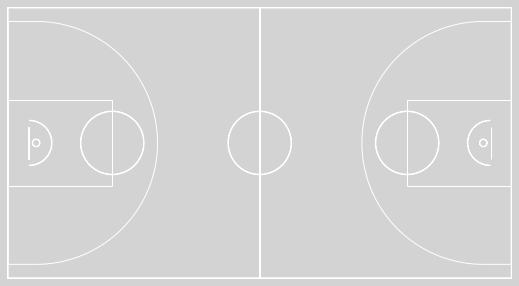

In [9]:
fig, ax = plt.subplots(figsize=(10, 5), facecolor="lightgray")
court.draw(ax=ax);

Not bad, right?

OK, next we need to cut down our dataframe to only include shots. I'm not sure what a lot of the columns are, but I do know that SX and SY are the x and y coordinates and that shots are denoted as one of P2, P3, or FT in the AC column. Free throws aren't included on the shot charts, so we can ignore those.

While we're at it, we're going to grab each team's ID from the schedule dataframe. If I've done this right, it should have teams shooting in the same direction as shown on the FIBA site.

We could also recover the colors for each team if we wanted, but that would require us to grab data from a different section of the API. So we'll set those manually instead.

In [10]:
shots = game_actions_df.query("AC in ('P2', 'P3')")

teams = [
    f"T_{team}" for team in (
        schedule_df
        .query("GameKey == @game_key")
        [[f"Competitor{team}_TeamId" for team in "AB"]]
        .values
        .ravel()
        .tolist()
    )
]

In [11]:
teamA_color = "red"    #@param
teamB_color = "yellow"    #@param

All that's left is the shot chart itself. The x, y coordinates are recorded as on a half court that looks like this:

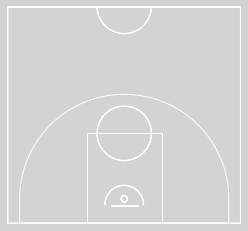

In [12]:
fig, ax = plt.subplots(facecolor="lightgray")
court.draw(ax=ax, rotation=270, display_range="half");

Also, both teams' shots are recorded on the same side of the court. So we'll need to transpose the coordinates and flip one team to be on the other side of center. I'm not going to follow the FIBA aesthetic exactly, but it should look close.

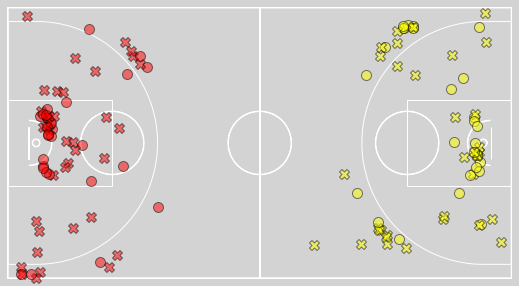

In [13]:
fig, ax = plt.subplots(figsize=(10, 5), facecolor="lightgray")
court.draw(ax=ax, rotation=0)

for shot in shots.itertuples():
    x = int(shot.SY)
    y = int(shot.SX)

    if shot.T1 == teams[0]:
        color = teamA_color
    else:
        x = 522 - x
        y = 280 - y
        color = teamB_color

    marker = "o" if shot.SU == "+" else "X"
    
    court.scatter(
        x, y, is_constrained=False, 
        color=color, alpha=0.5, edgecolor="black", 
        s=100, marker=marker,
    )

If you'd like to compare to the FIBA site, this game is:  
https://www.fiba.basketball/womensbasketballworldcup/2022/game/2209/USA-Belgium#|tab=shot_chart